In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import glob
import os
import contextily as ctx
from scipy.spatial import cKDTree
from shapely.geometry import Point
import json
from tqdm.auto import tqdm
pd.set_option('min_rows', 30)
import sys
sys.path.append('..')
from importlib import reload
# import src.utils as utils
# reload(utils)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [3]:
%%time
## read in and get bounds
df = pd.read_csv("input/BCs_issued_by_AUP_TLADCs_2021FEB.csv")
bcs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_Coordinate, df.Y_Coordinate))
# get bounds of data set (with a small buffer), useful for clipping other datasets
bcs = bcs.set_crs(epsg=4326)
bounds4326 = bcs.total_bounds
bcs = bcs.to_crs(epsg=3857)
bounds3857 =  bcs.total_bounds

CPU times: user 37.2 s, sys: 859 ms, total: 38 s
Wall time: 38 s


In [4]:
## add small buffer to bounds
x_delta3857 = bounds3857[2] - bounds3857[0]
y_delta3857 = bounds3857[3] - bounds3857[1]
bounds_buffered3857 = [bounds3857[0] - y_delta3857 / 200, bounds3857[1] - x_delta3857 / 200, bounds3857[2] + y_delta3857 / 200, bounds3857[3] + x_delta3857 / 200]
bounds_buffered3857
x_delta4326 = bounds4326[2] - bounds4326[0]
y_delta4326 = bounds4326[3] - bounds4326[1]
bounds_buffered4326 = [bounds4326[0] - y_delta4326 / 200, bounds4326[1] - x_delta4326 / 200, bounds4326[2] + y_delta4326 / 200, bounds4326[3] + x_delta4326 / 200]
bounds_buffered4326

[174.15865864485, -37.2937968355, 175.54295485515, -35.877583094500004]

In [5]:
# one address has no ADDRESS_1, but an ADDRESS_2 with a leading digit
display(bcs[bcs.ADDRESS_1.isna() & ~bcs.ADDRESS_2.isna()][bcs[bcs.ADDRESS_1.isna() & ~bcs.ADDRESS_2.isna()].ADDRESS_2.str.contains('^[0-9]', regex=True)])
# move address 2 to address 1 for that one BC...
bcs.loc[bcs.OBS == 146813, 'ADDRESS_1'] = "25 HOLLYFORD DRV"
bcs.loc[bcs.OBS == 146813, 'ADDRESS_2'] = ""

OBS              CONSENT_DATE                MARCH_YEAR ADDRESS_1  \
64127  146813  Sep 01, 2013 12:00:00 AM  Mar 01, 2013 12:00:00 AM       NaN   

              ADDRESS_2    ADDRESS_3 LB_Name  \
64127  25 HOLLYFORD DRV  CLOVER PARK  Howick   

                                      BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
64127  New (and pre-built) house, unit, bach, crib, b...                1100   

       FLOOR_AREA     VALUE  BUILDINGS Building_Type_Group Residential_Type  \
64127       239.0  240000.0          1         Residential         Detached   

      Business_Group Business_Category  Type_Class_Year    MBCODE  MBYEAR  \
64127            NaN               NaN             1998  716014.0  2013.0   

                                    AUP_BaseZone AUP_BaseZone_Group  ZONE  \
64127  Residential - Mixed Housing Suburban Zone        Residential  18.0   

      ZONE_ID         ZONE_NAME    ZONE_TYPE BUSINESS_TYPE PlanAreaName  \
64127  MCC_MR  Main Residential  Residential           NaN          NaN   

      SHA_Name_154  X_Coordinate  Y_Coordinate  \
64127          NaN    174.896997    -36.986932   

                                geometry  
64127  POINT (19469444.625 -4437285.457)

In [6]:
%%time
# get number and name of street (but not 'road', 'street', 'place' etc), for matching with addresses
def number_name_bc(x):
    """extract street number and first complete word of the street name from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3]]).lower()
        return ' '.join(joined_address.split(' ')[:2])

def full_address_bc(x):
    """extract full address from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3] if not str(x[f'ADDRESS_{i}']) == 'nan']).lower()
        return joined_address

bcs['number_name'] = bcs.apply(number_name_bc, axis=1)
bcs['full_address'] = bcs.apply(full_address_bc, axis=1)
# to have successfully extracted the name as the second 'word': the last character is never numeric
# print(sum(bcs['number_name'].apply(lambda x: x[-1] in [i for i in range(10)])))
# there will still be some cases where there is no street number
display(bcs.number_name.sample(5))

22947        45 station
65398     22a stottholm
5621         19 ventura
149709         3 tainui
6642          111 kuaka
Name: number_name, dtype: object

CPU times: user 28.9 s, sys: 500 ms, total: 29.4 s
Wall time: 29.4 s


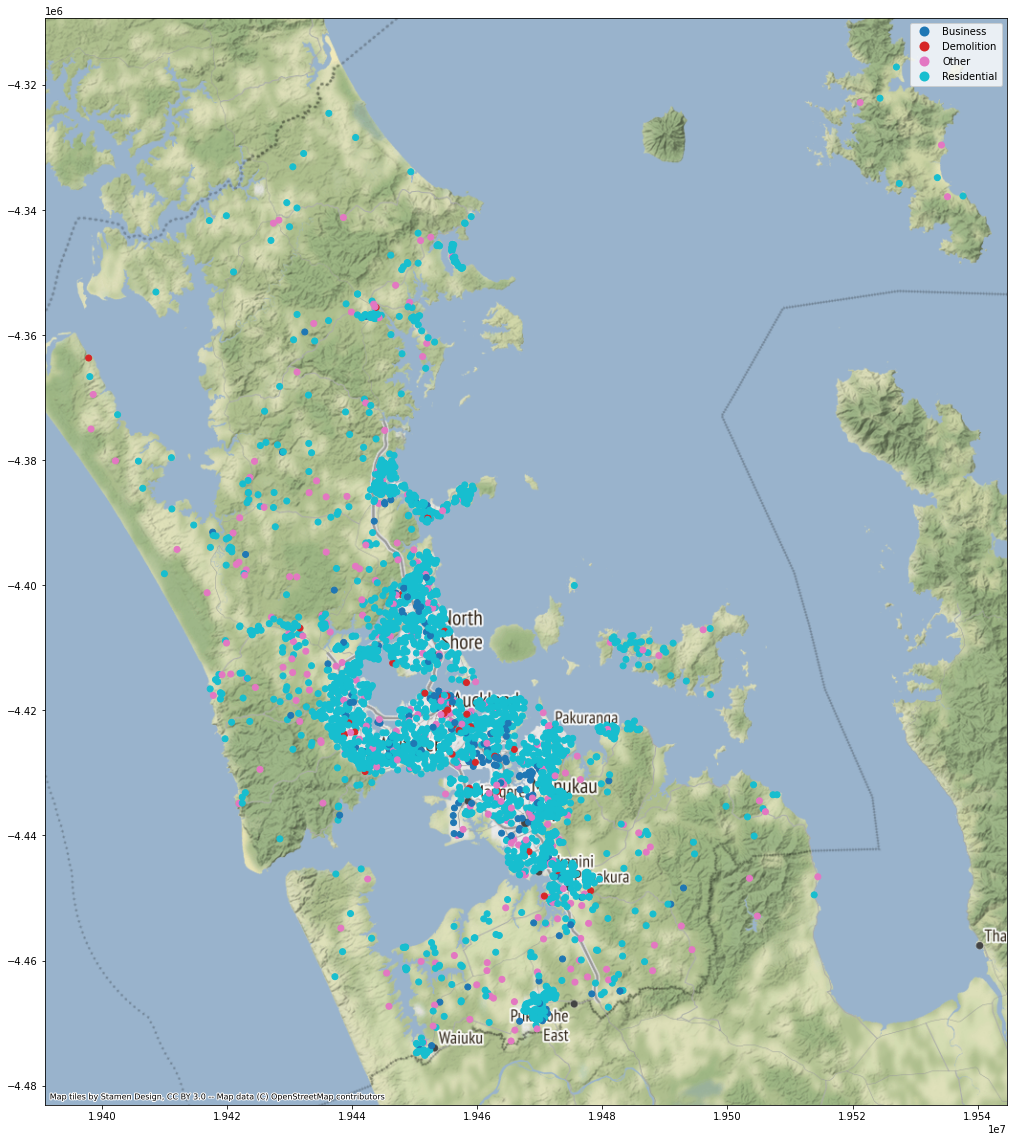

In [7]:
ax = bcs.sample(3000).plot(column='Building_Type_Group', legend=True, figsize=(20,20))
ctx.add_basemap(ax)

In [88]:
# split into three branches: those with an address number range (e.g. 10-20), those with a single number (e.g. 10), and those with no number
# those with no number cannot be matched with addresses to get a more accuract coordinate
bcs_non_na = bcs[~bcs.ADDRESS_1.isna()]
bcs_ranged = bcs_non_na[bcs_non_na.ADDRESS_1.str.contains('^[0-9]+-[0-9]', regex=True)]
# get all bcs which start with a digit
bcs_numbered = bcs_non_na[bcs_non_na.ADDRESS_1.str.contains('^[0-9]', regex=True)]
# exclude those in bcs_ranged
bcs_numbered = bcs_numbered[~bcs_numbered.ADDRESS_1.str.contains('^[0-9]+-[0-9]', regex=True)]
bcs_others = pd.concat([bcs_non_na[~bcs_non_na.ADDRESS_1.str.contains('^[0-9]', regex=True)], bcs[bcs.ADDRESS_1.isna()]])
print('non na:', len(bcs_non_na))
print('1. ranged:', len(bcs_ranged))
print('2. numbered:', len(bcs_numbered))
print('3. non ranged/non numbered:', len(bcs_others))
print('total bcs:', len(bcs))
print('sum of 1, 2, 3:', len(bcs_ranged) + len(bcs_numbered) + len(bcs_others))

non na: 193005
1. ranged: 6267
2. numbered: 183013
3. non ranged/non numbered: 17946
total bcs: 207226
sum of 1, 2, 3: 207226


In [12]:
# all ranges that have a non digit in them
rows = []
for index, row in tqdm(bcs_ranged.iterrows(), total=len(bcs_ranged)):
    r = row.number_name.split(' ')[0].split('/')[0]
    if not all([s.isdecimal() for s in r.split('-')]):
        print(row.number_name.split(' ')[0])
    rows.append(row)

  0%|          | 0/1105 [00:00<?, ?it/s]

1-1a
2-2a
9-9a
1-1a
3-5a
3-5a


## Get more accurate coordinates from NZ addresses dataset

In [14]:
# addressing of building consents is very inconsistent
# some building consents have street name in ADDRESS_2, some have suburb, some even have 'Auckland'
bcs[bcs.ADDRESS_2 == 'Auckland'].sample(5)

OBS              CONSENT_DATE                MARCH_YEAR  \
24601  188214  Nov 01, 2018 12:00:00 AM  Mar 01, 2019 12:00:00 AM   
24605  188218  Nov 01, 2018 12:00:00 AM  Mar 01, 2019 12:00:00 AM   
24606  188219  Nov 01, 2018 12:00:00 AM  Mar 01, 2019 12:00:00 AM   
24614  188227  Nov 01, 2018 12:00:00 AM  Mar 01, 2019 12:00:00 AM   
24618  188231  Nov 01, 2018 12:00:00 AM  Mar 01, 2019 12:00:00 AM   

                   ADDRESS_1 ADDRESS_2 ADDRESS_3             LB_Name  \
24601      528 DON BUCK ROAD  Auckland       NaN  Henderson - Massey   
24605      528 DON BUCK ROAD  Auckland       NaN  Henderson - Massey   
24606      528 DON BUCK ROAD  Auckland       NaN  Henderson - Massey   
24614  524-526 Don Buck Road  Auckland       NaN  Henderson - Massey   
24618      528 DON BUCK ROAD  Auckland       NaN  Henderson - Massey   

                                  BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
24601                      Non-building construction                3111   
24605  Townhouses, flats, units, and other dwellings                1129   
24606  Townhouses, flats, units, and other dwellings                1129   
24614  Townhouses, flats, units, and other dwellings                1129   
24618  Townhouses, flats, units, and other dwellings                1129   

       FLOOR_AREA     VALUE  BUILDINGS Building_Type_Group Residential_Type  \
24601         0.0   40000.0          1               Other              NaN   
24605       129.0  233100.0          1         Residential         Attached   
24606       104.0  188640.0          1         Residential         Attached   
24614       135.0  216000.0          1         Residential         Attached   
24618       136.0  245622.0          1         Residential         Attached   

      Business_Group Business_Category  Type_Class_Year    MBCODE  MBYEAR  \
24601            NaN               NaN             2014  226402.0  2013.0   
24605            NaN               NaN             2014  226402.0  2013.0   
24606            NaN               NaN             2014  226402.0  2013.0   
24614            NaN               NaN             2014  226403.0  2013.0   
24618            NaN               NaN             2014  226402.0  2013.0   

                                 AUP_BaseZone AUP_BaseZone_Group  ZONE  \
24601  Residential - Mixed Housing Urban Zone        Residential  60.0   
24605  Residential - Mixed Housing Urban Zone        Residential  60.0   
24606  Residential - Mixed Housing Urban Zone        Residential  60.0   
24614  Residential - Mixed Housing Urban Zone        Residential  60.0   
24618  Residential - Mixed Housing Urban Zone        Residential  60.0   

      ZONE_ID  ZONE_NAME    ZONE_TYPE BUSINESS_TYPE  \
24601   WCC_6  Foothills        Rural           NaN   
24605   WCC_6  Foothills        Rural           NaN   
24606   WCC_6  Foothills        Rural           NaN   
24614   WCC_7     Living  Residential           NaN   
24618   WCC_6  Foothills        Rural           NaN   

                                 PlanAreaName  \
24601  Redhills (Fred Taylor Drive) � Stage 1   
24605  Redhills (Fred Taylor Drive) � Stage 1   
24606  Redhills (Fred Taylor Drive) � Stage 1   
24614  Redhills (Fred Taylor Drive) � Stage 1   
24618  Redhills (Fred Taylor Drive) � Stage 1   

                                 SHA_Name_154  X_Coordinate  Y_Coordinate  \
24601  Redhills (Fred Taylor Drive) � Stage 1    174.603215    -36.824411   
24605  Redhills (Fred Taylor Drive) � Stage 1    174.603215    -36.824411   
24606  Redhills (Fred Taylor Drive) � Stage 1    174.603215    -36.824411   
24614  Redhills (Fred Taylor Drive) � Stage 1    174.607308    -36.824848   
24618  Redhills (Fred Taylor Drive) � Stage 1    174.603215    -36.824411   

                                geometry  
24601  POINT (19436740.940 -4414660.154)  
24605  POINT (19436740.940 -4414660.154)  
24606  POINT (19436740.940 -4414660.154)  
24614  POINT (19437196.626 -4414720.873)  
24618  POINT (1943

In [16]:
%%time
## read in address dataset and add number_name, just like for BCs
# https://data.linz.govt.nz/layer/53353-nz-street-address/
addresses = gpd.read_file('input/lds-nz-street-address-GPKG-CLIPPED.gpkg').to_crs(3857)
def number_name_addresses(x):
    return ' '.join(x.full_address.split(' ')[:2]).lower()
addresses['number_name'] = addresses.apply(number_name_addresses, axis=1)

/data/miniconda3/envs/house-upzone/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


CPU times: user 2min 5s, sys: 11 s, total: 2min 16s
Wall time: 2min 16s


In [17]:
addresses[(addresses.address_number == 9) & (addresses.full_road_name == 'Hopetoun Street')].sample(3)

address_id  change_id address_type unit_value  address_number  \
513953     1989299    2991221         Road        202               9   
513851     1915403    2991240         Road        502               9   
513854     1915406    2991245         Road        603               9   

       address_number_suffix  address_number_high water_route_name water_name  \
513953                  None                  NaN             None       None   
513851                  None                  NaN             None       None   
513854                  None                  NaN             None       None   

       suburb_locality town_city full_address_number   full_road_name  \
513953    Freemans Bay  Auckland               202/9  Hopetoun Street   
513851    Freemans Bay  Auckland               502/9  Hopetoun Street   
513854    Freemans Bay  Auckland               603/9  Hopetoun Street   

                                         full_address  road_section_id  \
513953  202/9 Hopetoun Street, Freemans Bay, Auckland           189772   
513851  502/9 Hopetoun Street, Freemans Bay, Auckland           189772   
513854  603/9 Hopetoun Street, Freemans Bay, Auckland           189772   

        gd2000_xcoord  gd2000_ycoord water_route_name_ascii water_name_ascii  \
513953     174.752374     -36.858544                   None             None   
513851     174.752374     -36.858544                   None             None   
513854     174.752374     -36.858544                   None             None   

       suburb_locality_ascii town_city_ascii full_road_name_ascii  \
513953          Freemans Bay        Auckland      Hopetoun Street   
513851          Freemans Bay        Auckland      Hopetoun Street   
513854          Freemans Bay        Auckland      Hopetoun Street   

                                   full_address_ascii  \
513953  202/9 Hopetoun Street, Freemans Bay, Auckland   
513851  502/9 Hopetoun Street, Freemans Bay, Auckland   
513854  603/9 Hopetoun Street, Freemans Bay, Auckland   

                                 geometry     number_name  
513953  POINT (19453345.297 -4419407.917)  202/9 hopetoun  
513851  POINT (19453345.297 -4419407.917)  502/9 hopetoun  
513854  POINT (19453345.297 -4419407.917)  603/9 hopetoun

In [333]:
addresses.sample(10)

address_id  change_id address_type unit_value  address_number  \
52975    1002801.0   889731.0         Road       None             2.0   
158403    998738.0   886362.0         Road       None            24.0   
596494   2227003.0  5300930.0         Road       1702            10.0   
318775   1921571.0  1745258.0         Road       None             7.0   
270718   1147783.0  1013962.0         Road       None             4.0   
124870   1878596.0  1834835.0         Road          1            95.0   
94373    1487614.0  1295132.0         Road       None            18.0   
202231   1498243.0  1304879.0         Road       None            87.0   
227912   1226642.0  1082889.0         Road       None            12.0   
434079   1489551.0  1296876.0         Road       None            11.0   

       address_number_suffix  address_number_high water_route_name water_name  \
52975                   None                  NaN             None       None   
158403                  None                  NaN             None       None   
596494                  None                  NaN             None       None   
318775                     B                  NaN             None       None   
270718                  None                  NaN             None       None   
124870                  None                  NaN             None       None   
94373                   None                  NaN             None       None   
202231                  None                  NaN             None       None   
227912                  None                  NaN             None       None   
434079                  None                  NaN             None       None   

         suburb_locality  town_city full_address_number    full_road_name  \
52975          Titirangi   Auckland                   2    Waerenga Place   
158403    Te Atatu South   Auckland                  24    Tiroroa Avenue   
596494  Auckland Central   Auckland             1702/10   Commerce Street   
318775        St Heliers   Auckland                  7B      Edison Place   
270718         Devonport   Auckland                   4       Huia Street   
124870        Papatoetoe   Auckland                1/95      Motatau Road   
94373          Riverhead  Riverhead                  18      Maude Street   
202231             Orewa      Orewa                  87    Tauranga Place   
227912       Clover Park   Auckland                  12      Pesaro Place   
434079         Riverhead  Riverhead                  11  Great North Road   

                                             full_address  road_section_id  \
52975               2 Waerenga Place, Titirangi, Auckland         171349.0   
158403        24 Tiroroa Avenue, Te Atatu South, Auckland         191180.0   
596494  1702/10 Commerce Street, Auckland Central, Auc...         164395.0   
318775              7B Edison Place, St Heliers, Auckland         203321.0   
270718                 4 Huia Street, Devonport, Auckland         192089.0   
124870            1/95 Motatau Road, Papatoetoe, Auckland         193672.0   
94373                          18 Maude Street, Riverhead         205312.0   
202231                           87 Tauranga Place, Orewa         204608.0   
227912             12 Pesaro Place, Clover Park, Auckland         185178.0   
434079                     11 Great North Road, Riverhead         167386.0   

        gd2000_xcoord  gd2000_ycoord water_route_name_ascii water_name_ascii  \
52975      174.653251     -36.934016                   None             None   
158403     174.648857     -36.869946                   None             None   
596494     174.768026     -36.845663                   None             None   
318775     174.843315     -36.867704                   None             None   
270718     174.792322     -36.830337                   None             None   
124870     174.863701     -36.961238                   None             None   
94373      174.593912     -36.756725         

In [141]:
# and alternative matching would have been to take the digits + the first n characters of each address up to but not including 'road', drive', 'avenue' etc... but that would have been messy
set([x.split(' ')[-1] for x in addresses.full_road_name])

{'1',
 '12',
 '16',
 '2',
 'Access',
 'Anchorage',
 'Ara-Kotinga',
 'Avenue',
 'Bay',
 'Boardwalk',
 'Boulevard',
 'Brae',
 'Broadway',
 'Bypass',
 'Carrowmore',
 'Central',
 'Circle',
 'Circus',
 'Close',
 'Common',
 'Concourse',
 'Court',
 'Courtneys',
 'Cove',
 'Crescent',
 'Crest',
 'Dale',
 'Dell',
 'Downs',
 'Drive',
 'Earlsway',
 'East',
 'Enclave',
 'End',
 'Esplanade',
 'Extension',
 'Fairway',
 'Fen',
 'Furlong',
 'Garden',
 'Gardens',
 'Glade',
 'Glebe',
 'Glen',
 'Goldfield',
 'Green',
 'Greens',
 'Grove',
 'Gully',
 'Harbour',
 'Haven',
 'Heights',
 'Highway',
 'Hill',
 'Hilltop',
 'Ho',
 'Homestead',
 'Island',
 'Isle',
 'Kingsway',
 'Knoll',
 'Landing',
 'Lane',
 'Lea',
 'Link',
 'Lochview',
 'Loop',
 'Mall',
 'Meadway',
 'Mermaid',
 'Mews',
 'Mile',
 'Motu',
 'Neptune',
 'Nook',
 'North',
 'Oaks',
 'Oasis',
 'Oho',
 'Oval',
 'Parade',
 'Park',
 'Parkway',
 'Pass',
 'Place',
 'Plaza',
 'Point',
 'Priors',
 'Prom',
 'Promenade',
 'Quadrant',
 'Queensway',
 'Reach',
 'Retr

In [29]:
%time
addresses_tree = cKDTree(np.array(list(addresses[~addresses.geometry.isna()].geometry.apply(lambda x: (x.x, x.y)))))
bcs_numbered_tree = cKDTree(np.array(list(bcs_numbered.geometry.apply(lambda x: (x.x, x.y)))))
bcs_ranged_tree = cKDTree(np.array(list(bcs_ranged.geometry.apply(lambda x: (x.x, x.y)))))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.3 µs


In [178]:
# test some radii to see which is suitable
bcs_numbered_sample = bcs_numbered.sample(1000)
bcs_numbered_sample_tree = cKDTree(np.array(list(bcs_numbered_sample.geometry.apply(lambda x: (x.x, x.y)))))
matches = {}
for r in [10, 50, 100, 175] + list(range(250, 3251, 250)):
    matches[r] = []
    # list of lists: ith sub list contains indices of use_tree points within r of the ith data_tree point
    bcs_numbered_neighbours = bcs_numbered_sample_tree.query_ball_tree(addresses_tree, r)
    for i, neighbours in tqdm(enumerate(bcs_numbered_neighbours)):
        # check how many matches there are
        matches[r].append(np.sum(bcs_numbered_sample.iloc[i].number_name == addresses.iloc[neighbours].number_name))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

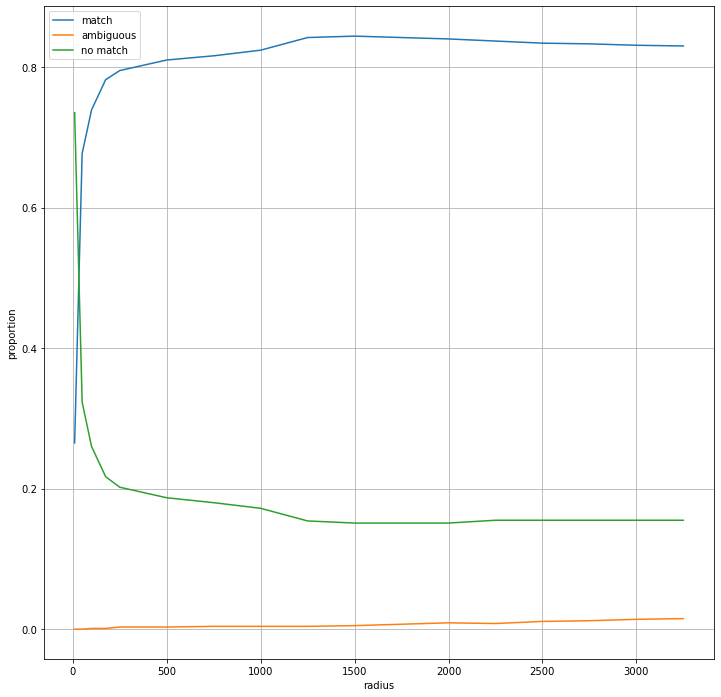

In [184]:
# for r in sorted(matches.keys()):
#     print('####', r, '####')
#     print('match:', np.sum(np.array(matches[r]) == 1) / len(matches[r]))
#     print('ambiguous:', np.sum(np.array(matches[r]) > 1) / len(matches[r]))
#     print('no match:', np.sum(np.array(matches[r]) == 0) / len(matches[r]))
r_list = list(sorted(matches.keys()))
ax = plt.subplot(1,1,1)
ax.plot(r_list, [np.sum(np.array(matches[r]) == 1) / len(matches[r]) for r in r_list], label='match')
ax.plot(r_list, [np.sum(np.array(matches[r]) > 1) / len(matches[r]) for r in r_list], label='ambiguous')
ax.plot(r_list, [np.sum(np.array(matches[r]) == 0) / len(matches[r]) for r in r_list], label='no match')
ax.legend()
plt.xlabel('radius')
plt.ylabel('proportion')
plt.grid()

In [30]:
# test some radii to see which is suitable
def unique_radius_column_match(left, right, left_col, right_col, r=1250, left_tree=None, right_tree=None):
    """find points in right that are within r of points in left and uniquely match on a column"""
    if right_tree is None:
        right_tree = cKDTree(np.array(list(right.geometry.apply(lambda x: (x.x, x.y)))))
    if left_tree is None:
        left_tree = cKDTree(np.array(list(left.geometry.apply(lambda x: (x.x, x.y)))))
    
    # specify columns and initialize neighbour information dictionary if using the less efficient method
    # columns = ('address_id', 'full_address', 'geometry')
    # neighbour_information = {c: [] for c in columns}
    match_indices = []
    # list of lists: ith sub list contains indices of right points within r of the ith left point
    left_tree_neighbours = left_tree.query_ball_tree(addresses_tree, r)
    for i, neighbours in tqdm(enumerate(left_tree_neighbours), total=len(left_tree_neighbours)):
        # subset right to those within r distance
        right_neighbours = addresses.iloc[neighbours]
        # check how many matches there are
        match_indicator = left.iloc[i][left_col] == right_neighbours[right_col]
        if np.sum(match_indicator) == 1:
            # extract the index from right_neighbours
            # extracting the index only and later subsetting the full addresses dataframe
            # results in a ~4x speed up over extracting the requisite addresses information within this for loop
            match_indices.append(right_neighbours[match_indicator].index[0])
        elif np.sum(match_indicator) > 1:
            match_indices.append(-1)
        else:
            match_indices.append(-2)
#     print('####', r, '####')
#     print('match:', np.sum(np.array(match_indices) > -1) / len(match_indices))
#     print('ambiguous:', np.sum(np.array(match_indices) == -1) / len(match_indices))
#     print('no match:', np.sum(np.array(match_indices) == -2) / len(match_indices))
    return match_indices

In [20]:
# add empty row with index -1; this will be retrieved if there is no match address match
addresses.loc[-1] = addresses.loc[1]
for c in addresses.columns:
    addresses.loc[-1, c] = np.nan
    addresses.loc[-1, c]
addresses.loc[-2] = addresses.loc[-1]

In [89]:
bcs_numbered_sample = bcs_numbered.sample(100)

In [41]:
addresses.loc[match_indices].geometry.reset_index(drop=True)

0    POINT (19445145.208 -4381779.063)
1    POINT (19431050.314 -4406402.836)
2    POINT (19451295.075 -4424310.520)
3    POINT (19472792.559 -4428320.864)
4                                 None
5    POINT (19451798.838 -4402948.354)
6    POINT (19448871.690 -4388815.649)
7                                 None
8    POINT (19441001.992 -4419707.478)
9    POINT (19471097.591 -4435539.799)
Name: geometry, dtype: geometry

In [90]:
r = 1250
match_col = 'number_name'
match_indices = unique_radius_column_match(bcs_numbered_sample, addresses, match_col, match_col, r=r, right_tree=addresses_tree)
bcs_numbered_sample['addresses_geometry'] = addresses.loc[match_indices].geometry.reset_index(drop=True).tolist()
bcs_numbered_sample['addresses_full_address'] = addresses.loc[match_indices].full_address.reset_index(drop=True).tolist()
bcs_numbered_sample['euc_distance'] = [np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) for a, b in zip(bcs_numbered_sample.geometry.apply(lambda x: (x.x, x.y)), bcs_numbered_sample['addresses_geometry'].apply(lambda x: (x.x, x.y) if not pd.isna(x) else (0, 0)))]

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Distance to Matched Address (metres)')

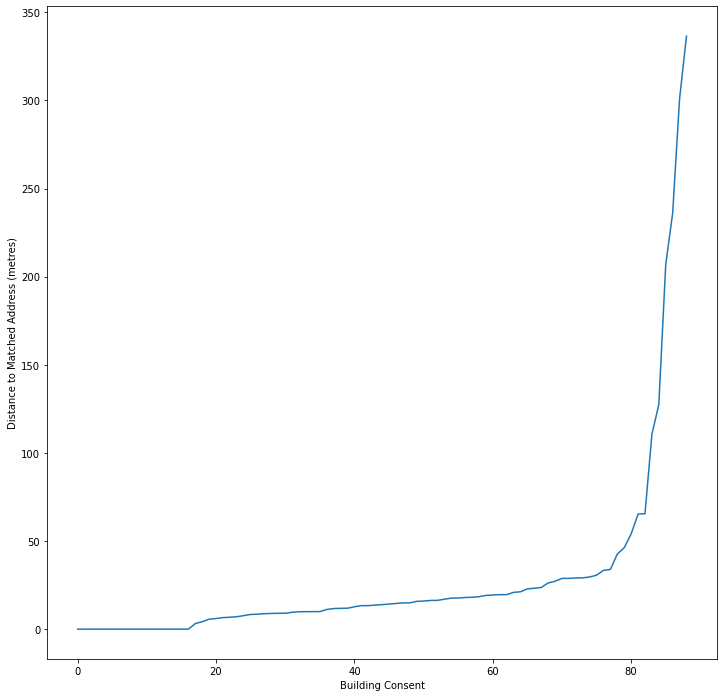

In [102]:
bcs_numbered_sample[~bcs_numbered_sample.addresses_full_address.isna()].sort_values('euc_distance').reset_index(drop=True).euc_distance.plot()
plt.xlabel('Building Consent')
plt.ylabel('Distance to Matched Address (metres)')

In [91]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(bcs_numbered_sample.sort_values('euc_distance')[['full_address', 'addresses_full_address']])

full_address  \
11910        302 buckland road mangere east auckland   
14559             15f wonderview road leigh auckland   
23042       41 sunshine boulevard sunnyvale auckland   
27621            5 cory road waiheke island auckland   
12352           22 aorangi place birkenhead auckland   
27689             75 litten road cockle bay auckland   
1255             2 hakanoa street grey lynn auckland   
7325         26 longfellow parade titirangi auckland   
5807               2 riverside drive waiuku auckland   
4631                  40 rimu road manurewa auckland   
25134                8 paneika lane otahuhu auckland   
1597             141 boundary road papakura auckland   
6980              30 boocock crescent orewa auckland   
25427         1 three oaks drive dairy flat auckland   
22942             23 dinning road riverhead auckland   
26829              1 campbell road maraetai auckland   
19203           88 godfrey drive silverdale auckland   
89353                       9 may ave te atatu south   
65938                           17 arion rd takanini   
53063         20 whaley greens silverdale silverdale   
179340                         53 motutapu ave manly   
64497                    13 wisteria lane silverdale   
147021                            6 aldern rd massey   
60541                           2 conti dr flat bush   
78764                          3 ruze vida dr massey   
35010               8 bomber lane whenuapai auckland   
149815                   24 chateau rise east tamaki   
54053       50 golden morning dr albany heights 0632   
46805                 52 pohutukawa parade riverhead   
46381                           3 lagonda rise oteha   
42674                         16 hakaro way takanini   
141546                          13 bejoy rise howick   
168598                 18a newell st point chevalier   
176966                     4 sonterra close manurewa   
51613                  18 hooton drive huapai huapai   
165221                         7 fintry pl flat bush   
67261                     38 ashlynne ave papatoetoe   
112620                   108 picasso dr west harbour   
104439                  105 duck creek rd stillwater   
180331                           7 wharf st papakura   
158528                        90 kittiwake dr albany   
159272                    44 ploughmans ave pukekohe   
35124            39 rautahi terrace redvale auckland   
79595                            43 james st mangere   
152618                           50 tiriwa dr massey   
174996                     3 springtide pl red beach   
149027                    30 lynton rd mt wellington   
194750                      3 feeny cres east tamaki   
72140                           43 landing dr albany   
66497                     96a harris street pukekohe   
203287                        30 premila dr pukekohe   
88891                               8 pono pl waiuku   
126494                         4 argyle ave papakura   
125141                       1 highwood grove torbay   
29981      21 derrimore heights clover park auckland   
163003                      3 dellwood ave henderson   
114145                         5 rawson way takanini   
94953                     2/21 aorangi pl birkenhead   
167225                   89 mt lebanon cres manurewa   
173149                     7 drumbeg close flat bush   
78888                          9 blanc rd silverdale   
106131                        16 te hoe grove albany   
31267        91 karepiro drive stanmore bay auckland   
108386                      95 atkin ave mission bay   
146677                  26 duncansby rd stanmore bay   
45224                  2 gallantry crescent papakura   
154737                    74 rangitoto rd papatoetoe   
169823                       39 hanene st st heliers   
116371                    57 picasso dr west harbour   
64541                   50 corricvale way northcross   
31281              2 valley road browns bay auckland   
170825  

In [189]:
addresses_no_na[addresses_no_na.full_address.str.contains('^[0-9]*\/303 Flat Bush', regex=True)]

Empty GeoDataFrame
Columns: [address_id, change_id, address_type, unit_value, address_number, address_number_suffix, address_number_high, water_route_name, water_name, suburb_locality, town_city, full_address_number, full_road_name, full_address, road_section_id, gd2000_xcoord, gd2000_ycoord, water_route_name_ascii, water_name_ascii, suburb_locality_ascii, town_city_ascii, full_road_name_ascii, full_address_ascii, geometry, number_name]
Index: []

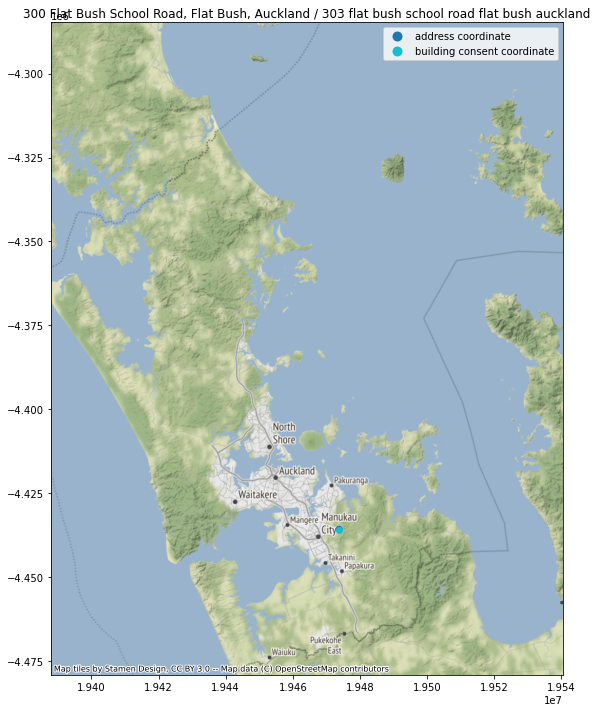

In [188]:
addresses_no_na = addresses[~addresses.full_address.isna()]
address_points = addresses_no_na[addresses_no_na.full_address.str.contains('^300 Flat', regex=True)].assign(source='address coordinate')
bcs_points = bcs.loc[[13441]].assign(source='building consent coordinate')
ax = pd.concat([address_points[['source', 'geometry']], bcs_points[['source', 'geometry']]]).plot(column='source', legend=True)
plt.xlim(bounds3857[0], bounds3857[2])
plt.ylim(bounds3857[1], bounds3857[3])
plt.title(address_points.full_address.values[0] + ' / ' + bcs_points.full_address.values[0])
ctx.add_basemap(ax)

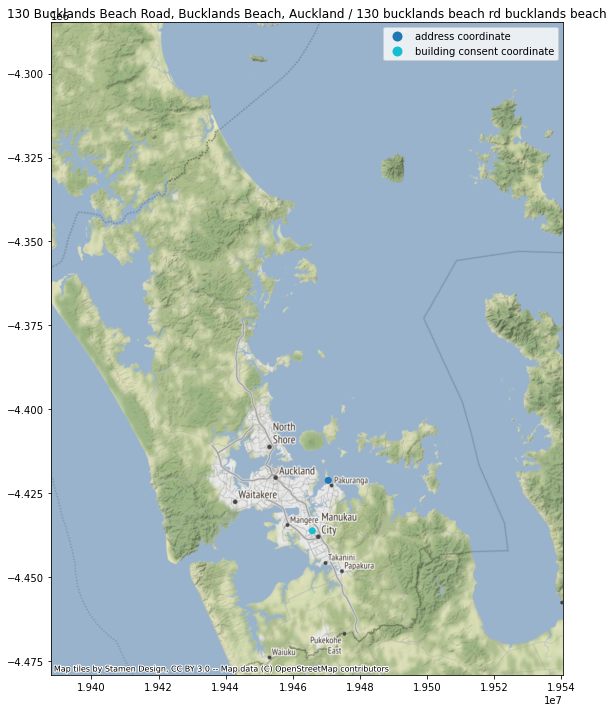

In [180]:
addresses_no_na = addresses[~addresses.full_address.isna()]
address_points = addresses_no_na[addresses_no_na.full_address.str.contains('^130 Bucklands Beach', regex=True)].assign(source='address coordinate')
bcs_points = bcs.loc[[114640]].assign(source='building consent coordinate')
ax = pd.concat([address_points[['source', 'geometry']], bcs_points[['source', 'geometry']]]).plot(column='source', legend=True)
plt.xlim(bounds3857[0], bounds3857[2])
plt.ylim(bounds3857[1], bounds3857[3])
plt.title(address_points.full_address.values[0] + ' / ' + bcs_points.full_address.values[0])
ctx.add_basemap(ax)

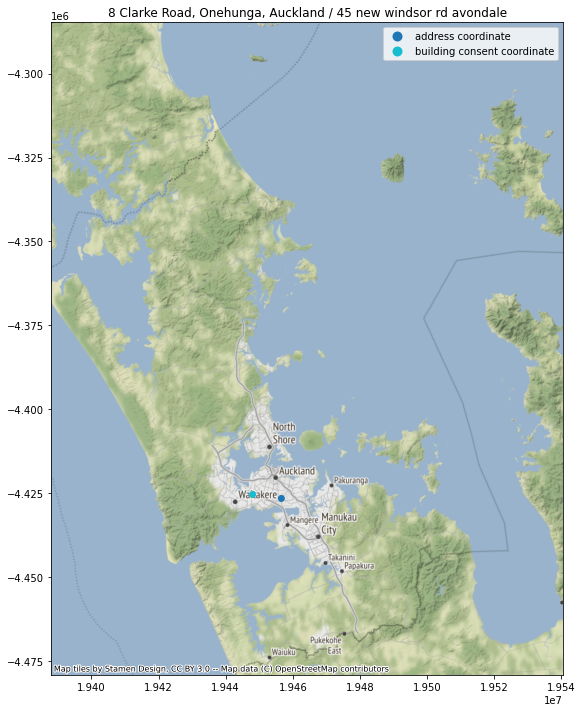

In [179]:
addresses_no_na = addresses[~addresses.full_address.isna()]
address_points = addresses_no_na[addresses_no_na.full_address.str.contains('^8 Clarke Road, Oneh', regex=True)].assign(source='address coordinate')
bcs_points = bcs.loc[[167989]].assign(source='building consent coordinate')
ax = pd.concat([address_points[['source', 'geometry']], bcs_points[['source', 'geometry']]]).plot(column='source', legend=True)
plt.xlim(bounds3857[0], bounds3857[2])
plt.ylim(bounds3857[1], bounds3857[3])
plt.title(address_points.full_address.values[0] + ' / ' + bcs_points.full_address.values[0])
ctx.add_basemap(ax)

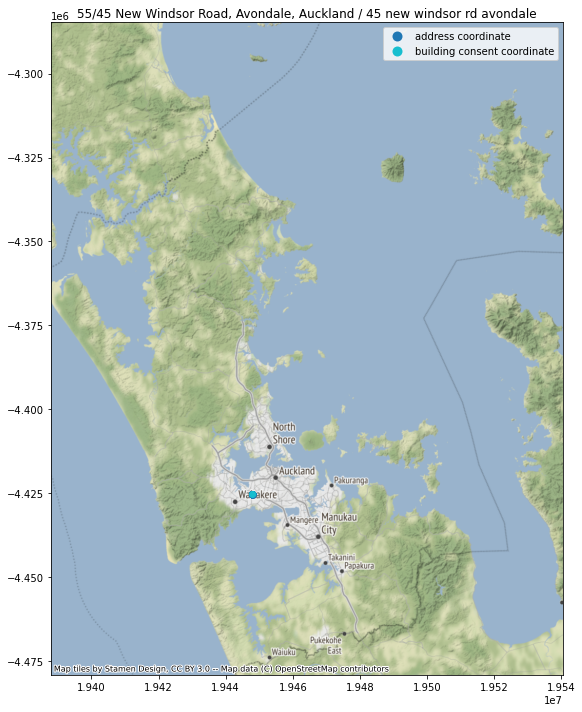

In [190]:
# no exact 45 - needs to have a flat
addresses_no_na = addresses[~addresses.full_address.isna()]
address_points = addresses_no_na[addresses_no_na.full_address.str.contains('^[0-9]*\/45 New Windsor', regex=True)].assign(source='address coordinate')
bcs_points = bcs.loc[[167989]].assign(source='building consent coordinate')
ax = pd.concat([address_points[['source', 'geometry']], bcs_points[['source', 'geometry']]]).plot(column='source', legend=True)
plt.xlim(bounds3857[0], bounds3857[2])
plt.ylim(bounds3857[1], bounds3857[3])
plt.title(address_points.full_address.values[0] + ' / ' + bcs_points.full_address.values[0])
ctx.add_basemap(ax)

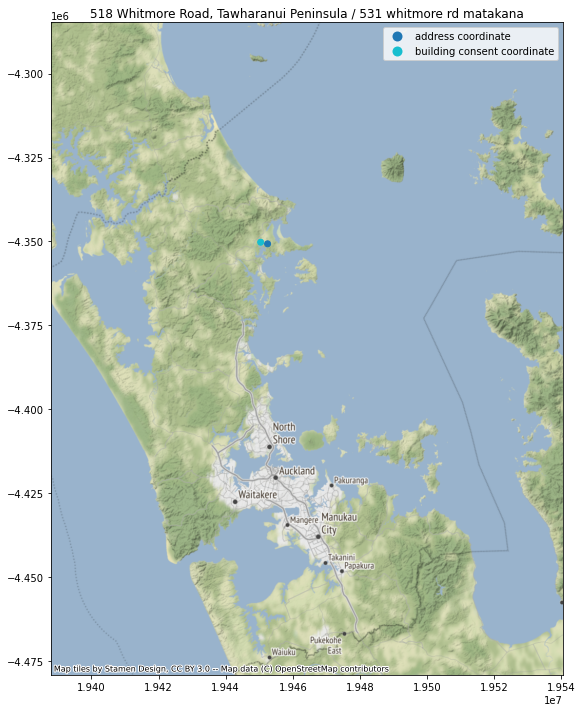

In [194]:
# no 531, even with a flat
addresses_no_na = addresses[~addresses.full_address.isna()]
address_points = addresses_no_na[addresses_no_na.full_address.str.contains('^51. Whitmore', regex=True)].assign(source='address coordinate')
bcs_points = bcs.loc[[73814]].assign(source='building consent coordinate')
ax = pd.concat([address_points[['source', 'geometry']], bcs_points[['source', 'geometry']]]).plot(column='source', legend=True)
plt.xlim(bounds3857[0], bounds3857[2])
plt.ylim(bounds3857[1], bounds3857[3])
plt.title(address_points.full_address.values[0] + ' / ' + bcs_points.full_address.values[0])
ctx.add_basemap(ax)

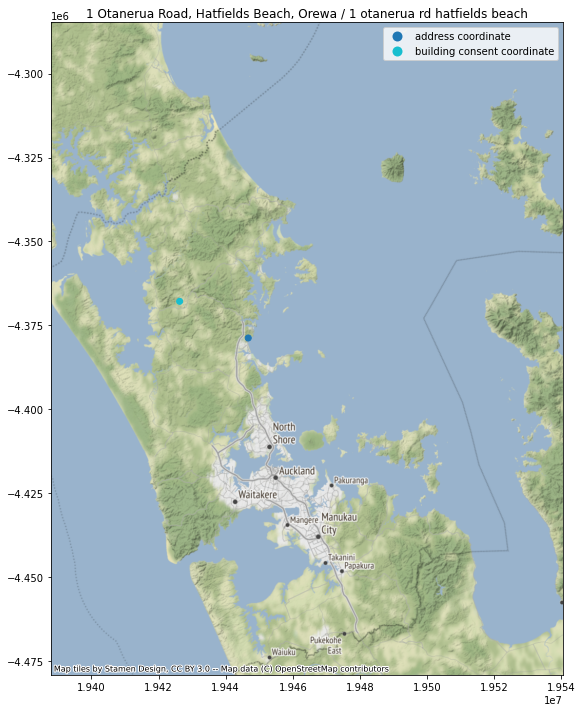

In [158]:
# way off
addresses_no_na = addresses[~addresses.full_address.isna()]
address_points = addresses_no_na[addresses_no_na.full_address.str.contains('^1 Otanerua', regex=True)].assign(source='address coordinate')
bcs_points = bcs.loc[[180116]].assign(source='building consent coordinate')
ax = pd.concat([address_points[['source', 'geometry']], bcs_points[['source', 'geometry']]]).plot(column='source', legend=True)
plt.xlim(bounds3857[0], bounds3857[2])
plt.ylim(bounds3857[1], bounds3857[3])
plt.title(address_points.full_address.values[0] + ' / ' + bcs_points.full_address.values[0])
ctx.add_basemap(ax)

In [11]:
def range_expand(r):
    if '/' in r:
        r, suffix = r.split('/')
        suffix = '/' + suffix
    else:
        suffix = ''
    r1, r2 = r.split('-')
    if r1.isdecimal() and r2.isdecimal():
        return [str(i) + suffix for i in range(int(r1), int(r2) + 1)]
    else:
        return r + suffix

In [13]:
ranged_list = []
for index, row in tqdm(bcs_ranged.iterrows(), total=len(bcs_ranged)):
    number_name = row.number_name.split(' ')
    number = number_name[0]
    name = number_name[1]
    range_expanded = range_expand(number)
    
    range_rows = [row.copy() for _ in range(len(range_expanded))]
    for i, rr in enumerate(range_rows):
        rr.number_name = range_expanded[i] + ' ' + name
    
    ranged_list.append(pd.DataFrame(range_rows))

  0%|          | 0/1105 [00:00<?, ?it/s]

In [299]:
# number of building consents that don't have NA for ADDRESS_1, and also don't have an address starting with a number
len([a for a in bcs[~bcs.ADDRESS_1.isna()].ADDRESS_1 if not a[0] in [str(i) for i in range(10)]])

3725

## Join BCs with NZ Parcels

In [37]:
%%time
nz_parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb')
print(nz_parcels.crs)
nz_parcels = nz_parcels.to_crs(3857)
nz_parcels = nz_parcels.cx[bounds_buffered3857[0]:bounds_buffered3857[2], bounds_buffered3857[1]:bounds_buffered3857[3]]

epsg:4167
CPU times: user 3min 58s, sys: 1.15 s, total: 3min 59s
Wall time: 3min 59s


In [45]:
nz_parcels = nz_parcels.cx[bounds_buffered3857[0]:bounds_buffered3857[2], bounds_buffered3857[1]:bounds_buffered3857[3]]

In [40]:
nz_parcels

id                                        appellation  \
0       5266447                                               None   
1       4789727     Part Lot 3 Allot 64 Section 1 SBRS OF Auckland   
2       4810316  Part Tidal Lands of Manukau Harbour Survey Off...   
3       4817943                Crown Land Survey Office Plan 58175   
4       4827816                                    Lot 2 DP 165098   
5       4937273                                     Lot 2 DP 38555   
6       4991598                                    Lot 161 DP 6975   
7       5008028                                    Lot 3 DP 155195   
8       5014167                                         Crown Land   
9       5030697                                     Lot 4 DP 61316   
10      5266127                                               None   
11      5043516  Part Tidal Lands of Manukau Harbour Survey Off...   
12      5074709                Crown Land Survey Office Plan 44403   
13      5116430                                     Lot 2 DP 58587   
14      5122300                                     Lot 3 DP 22134   
...         ...                                                ...   
537275  8022000                                    Lot 1 DP 522526   
537276  7264068                                  Lot 615 DP 429024   
537277  7264056                                   Lot 51 DP 429024   
537278  7190462                                  Lot 548 DP 420258   
537279  7266272                                  Lot 536 DP 427884   
537280  7264079                                  Lot 626 DP 429024   
537281  5130443                                    Lot 30 DP 17583   
537282  7535538                                   Lot 88 DP 469841   
537283  7264099                                  Lot 646 DP 429024   
537284  8054279                                   Lot 24 DP 533358   
537285  7291940                                  Lot 745 DP 433546   
537286  7266269                                  Lot 533 DP 427884   
537287  8051540                                    Lot 8 DP 533517   
537288  7264065                                  Lot 518 DP 429024   
537289  7266268                                  Lot 532 DP 427884   

            affected_surveys     parcel_intent topology_type  \
0                       None             Hydro       Primary   
1                     SO 663              DCDB       Primary   
2                   SO 67474              DCDB       Primary   
3                   SO 58175              DCDB       Primary   
4                  DP 165098              DCDB       Primary   
5                   DP 38555              DCDB       Primary   
6                    DP 6975              DCDB       Primary   
7                  DP 155195              DCDB       Primary   
8                       None              DCDB       Primary   
9                   DP 61316              DCDB       Primary   
10                      None             Hydro       Primary   
11                  SO 67474              DCDB       Primary   
12                  SO 44403              DCDB       Primary   
13                  DP 58587              DCDB       Primary   
14                  DP 22134              DCDB       Primary   
...                      ...               ...           ...   
537275             DP 522526  Fee Simple Title       Primary   
537276  DP 429024, LT 450627  Fee Simple Title       Primary   
537277             DP 429024  Fee Simple Title       Primary   
537278             DP 420258  Fee Simple Title       Primary   
537279  DP 427884, LT 454543  Fee Simple Title       Primary   
537280             DP 429024  Fee Simple Title       Primary   
537281   DP 17583, DP 531059              DCDB       Primary   
537282             DP 469841  Fee Simple Title       Primary   
537283             DP 429024  Fee Simple Title       Primary   
537284             DP 533358  Fee Simple Title       Primary   
537285             DP 433546  Fee Simple Tit

# join with SA2s

In [13]:
sa2 = gpd.read_file('NZ-SA/statistical-area-2-2020-generalised.gdb')
sa2 = sa2.to_crs(3857)

In [20]:
gpd.sjoin(bc_sample, sa2)

OBS              CONSENT_DATE                MARCH_YEAR  \
6440    219437  Aug 01, 2020 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
203270   65577  Mar 01, 2000 12:00:00 AM  Apr 01, 2000 12:00:00 AM   
66156   144992  May 01, 2013 12:00:00 AM  Mar 01, 2013 12:00:00 AM   
91368    39665  Jan 01, 1997 12:00:00 AM  Apr 01, 1997 12:00:00 AM   
10567   211720  Mar 01, 2020 12:00:00 AM  Mar 01, 2020 12:00:00 AM   

                   ADDRESS_1      ADDRESS_2        ADDRESS_3  \
6440    13 GRIFFEN PARK ROAD  Mount Roskill         Auckland   
203270                              DUNN RD            DRURY   
66156                     39   BEACHWOOD DR  HATFIELDS BEACH   
91368                     45    PALOMINO DR  WESTERN HEIGHTS   
10567          61 CLARK ROAD    Hobsonville         Auckland   

                   LB_Name                                 BUILDING_TYPE_NAME  \
6440            Puketapapa      Townhouses, flats, units, and other dwellings   
203270            Franklin  New (and pre-built) house, unit, bach, crib, b...   
66156    Hibiscus and Bays  New (and pre-built) house, unit, bach, crib, b...   
91368   Henderson - Massey  New (and pre-built) house, unit, bach, crib, b...   
10567        Upper Harbour      Townhouses, flats, units, and other dwellings   

        BUILDING_TYPE_CODE  FLOOR_AREA     VALUE  BUILDINGS  \
6440                  1129       634.0       NaN          3   
203270                1100       207.0   95000.0          1   
66156                 1100       203.0  354000.0          1   
91368                 1100       210.0  100000.0          1   
10567                 1129        95.0  240000.0          1   

       Building_Type_Group Residential_Type Business_Group Business_Category  \
6440           Residential         Attached            NaN               NaN   
203270         Residential         Detached            NaN               NaN   
66156          Residential         Detached            NaN               NaN   
91368          Residential         Detached            NaN               NaN   
10567          Residential         Attached            NaN               NaN   

        Type_Class_Year    MBCODE  MBYEAR  \
6440               2014  587000.0  2013.0   
203270             1998  815401.0  2013.0   
66156              1998  170807.0  2013.0   
91368              1998  281514.0  2013.0   
10567              2014  222800.0  2013.0   

                                             AUP_BaseZone AUP_BaseZone_Group  \
6440    Residential - Terrace Housing and Apartment Bu...        Residential   
203270                                               Road            General   
66156                     Residential - Single House Zone        Residential   
91368              Residential - Mixed Housing Urban Zone        Residential   
10567              Residential - Mixed Housing Urban Zone        Residential   

        ZONE ZONE_ID                 ZONE_NAME    ZONE_TYPE BUSINESS_TYPE  \
6440     8.0  ACC_24            Residential 6a  Residential           NaN   
203270  27.0     NaN                       NaN          NaN           NaN   
66156   19.0  RDC_27  Residential Medium Inten  Residential           NaN   
91368   60.0   WCC_7                    Living  Residential           NaN   
10567   60.0  WCC_16              Special Area      Special           NaN   

                                             PlanAreaName  \
6440                                                  NaN   
203270                                                NaN   
66156                                                 NaN   
91368                                                 NaN   
10567   Scott Point, Sunderland Precinct, Hobsonville ...   

                                             SHA_Name_154  X_Coordinate  \
6440                                                  NaN    174.719937   
203270                                                NaN    175.052449   
66156                                              